<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#MSM-on-Prinz-potential" data-toc-modified-id="MSM-on-Prinz-potential-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>MSM on Prinz potential</a></span></li></ul></div>

# MSM on Prinz potential

In this example we study the estimation of a Markov state model based on particles living in the [Prinz potential landscape](../api/generated/deeptime.data.prinz_potential.rst).

In [1]:
from matplotlib import pyplot as plt
import numpy as np

from deeptime.clustering import BoxDiscretization
from deeptime.markov import TransitionCountEstimator
from deeptime.markov.msm import MaximumLikelihoodMSM
from deeptime.data import prinz_potential

First, we create the Prinz potential system and generate a plot of its potential function.

Text(0, 0.5, 'V(x)')

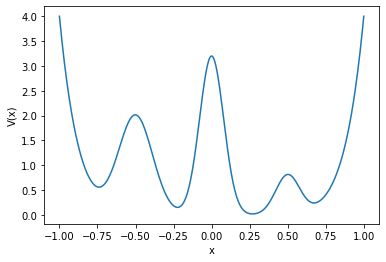

In [2]:
prinz_system = prinz_potential()

xs = np.linspace(-1., 1., 500)
ys = prinz_system.potential(xs)
plt.plot(xs, ys)
plt.xlabel('x')
plt.ylabel('V(x)')

Now we can simulate trajectories for 50 particles, each starting in the origin $x=0$ and generating 20000 frames.

In [3]:
data = prinz_system.trajectory(np.zeros((50, 1)), 20000)
print(f"Output shape {data.shape} for {data.shape[0]} particles, {data.shape[1]} frames "
      f"in {data.shape[2]} dimension.")

Output shape (50, 20000, 1) for 50 particles, 20000 frames in 1 dimension.


A histogram over the obtained data reflects the (inverse) potential landscape.

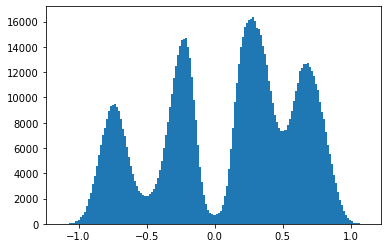

In [4]:
plt.hist(np.concatenate(data), bins=150);

We want to generate a sequence of MSMs under lagtime $\tau=2$ and varying accuracy regarding the spatial clustering.

In [5]:
lag = 2
n_clusters = [5, 7, 10, 15, 30, 50]

Each number of clusters yields a discretization which we use to build a MSM.

In [6]:
clusterings, msms = [], []

for n in n_clusters:
    cluster = BoxDiscretization(1, n, v0=[-1], v1=[1]).fit_fetch(np.concatenate(data))
    clusterings.append(cluster)
    
    dtrajs = [cluster.transform(x) for x in data]
    
    count_model = TransitionCountEstimator(lag, 'sliding').fit_fetch(dtrajs)
    msm = MaximumLikelihoodMSM().fit_fetch(count_model.submodel_largest())
    msms.append(msm)

We can now look at different properties of the estimated MSMs.

The transition matrices from coarse to fine with states ordered from left to right in configuration space:

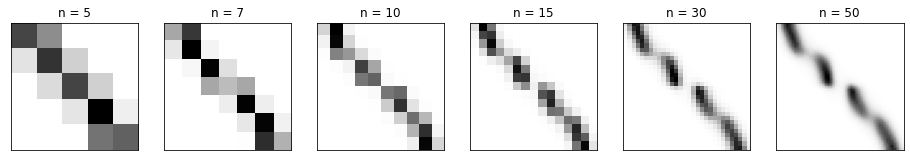

In [7]:
f, axes = plt.subplots(nrows=1, ncols=len(msms), figsize=(16, 5))

for ax, msm in zip(axes, msms):
    ax.imshow(msm.transition_matrix, cmap=plt.cm.Greys)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'n = {msm.n_states}')

The stationary distribution and first three nontrivial eigenfunctions:

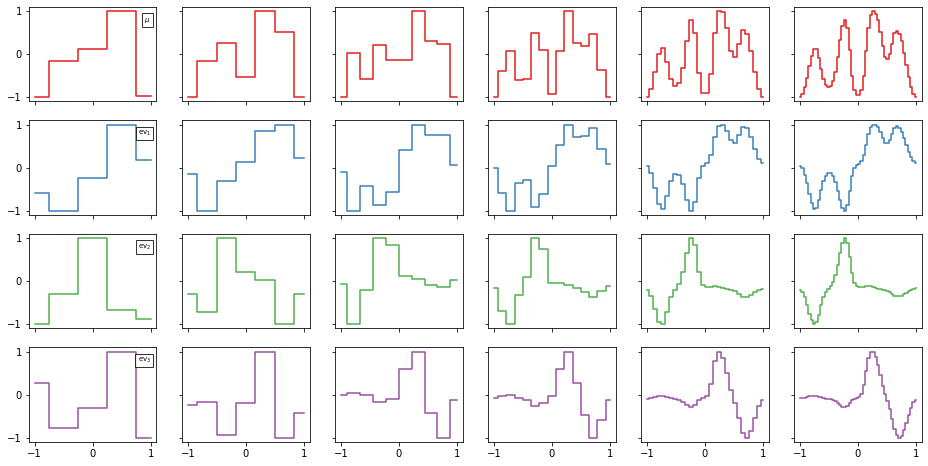

In [8]:
n_eigenfunctions = 4
cmap = plt.cm.Set1

f, axes = plt.subplots(nrows=n_eigenfunctions, ncols=len(msms), figsize=(16, 8), sharex=True, sharey=True)

finest_cl = clusterings[-1]
finest_msm = msms[-1]

for n, (msm, cluster) in enumerate(zip(msms, clusterings)):
    eigenvectors = msm.eigenvectors_left()
    for eig_n in range(n_eigenfunctions):
        ax = axes[eig_n, n]
        
        y = eigenvectors.T[:, eig_n]
        y = 2*(y-y.min())/(y.max() - y.min()) - 1  # rescale
        
        y0_ = finest_msm.eigenvectors_left().T[:, eig_n] / finest_msm.eigenvectors_left().T[:, eig_n].max()
        y0 = np.interp(cluster.cluster_centers[:, 0], finest_cl.cluster_centers[:, 0], y0_)
        
        if ((-y-y0)**2).sum() < ((y-y0)**2).sum():
            y = -y
        
        ax.step(cluster.cluster_centers[:, 0], y, color=cmap(eig_n), where='mid')
        
        if n == 0:
            lbl = r'$\mu$' if eig_n == 0 else r'$\mathrm{{ev}}_{{{}}}$'.format(eig_n)
            props = dict(boxstyle='square', facecolor='white', alpha=.8)
            ax.text(1., .9, lbl, verticalalignment='top', horizontalalignment='right', 
                           bbox=props, fontsize='x-small')

And finally, the timescales depending on the coarseness of the MSM.

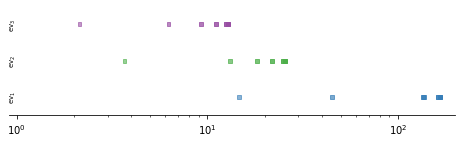

In [9]:
length = n_eigenfunctions - 1
ys = np.arange(length)

f, ax = plt.subplots(1, 1, figsize=(8, 2))

for n, msm in enumerate(msms):
    colors = []
    for i in range(length):
        colors.append(list(cmap(i+1)))
        colors[-1][-1] = ((n+1+len(msms))/(2*len(msms)))
    ax.scatter(msm.timescales(k=length), ys, c=colors, marker='s', s=15)
ax.semilogx()
ax.set_ylim(-.5, 2.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlim(.91, 1.99e2)
ax.set_yticks([])

for n in range(3):
    ax.text(0.91, n, r'$\mathrm{{ev}}_{{{}}}$'.format(n+1), 
             va='center', ha='left', fontsize='x-small', rotation=90)